In [ ]:
!pip install super-gradients

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [ ]:
%cd /mydrive/Yolo_Nas

/content/gdrive/My Drive/Yolo_Nas


In [ ]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

The console stream is logged into /root/sg_logs/console.log


[2023-10-16 17:38:26] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-10-16 17:38:26] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-10-16 17:38:33] INFO - utils.py - NumExpr defaulting to 2 threads.
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 78.5MB/s]
[2023-10-16 17:38:37] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-10-16 17:38:37] WARNING - export.py - Failed to import pytorch_quantization
[2023-10-16 17:38:37] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [ ]:
ROOT_DIR = 'pothole'
train_imgs_dir = 'train/images'
train_labels_dir = 'train/labels'
val_imgs_dir = 'valid/images'
val_labels_dir = 'valid/labels'
test_imgs_dir = 'test/images'
test_labels_dir = 'test/labels'
classes = ['Road-Hole']

dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes
}

In [ ]:
# Global parameters.
EPOCHS = 10
BATCH_SIZE = 16
WORKERS = 8

In [ ]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

[2023-10-16 17:43:09] WARNING - yolo_format_detection.py - 4 images are note associated to any label file
[2023-10-16 17:43:09] WARNING - yolo_format_detection.py - As a consequence, 497/501 images and 497/497 label files will be used.
[2023-10-16 17:43:09] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 497/497 [00:01<00:00, 366.06it/s]
[2023-10-16 17:43:11] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [ ]:
train_data.dataset.transforms[0]

DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114)

In [ ]:
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_empty_targets': False, 'swap': (2, 0, 1), 'input_dim': (640, 640), 'pad_value': 114),
 DetectionTargetsFormatTransform('additional_samples_count': 0, 'non_empty_targets': False, 'input_format': OrderedDi

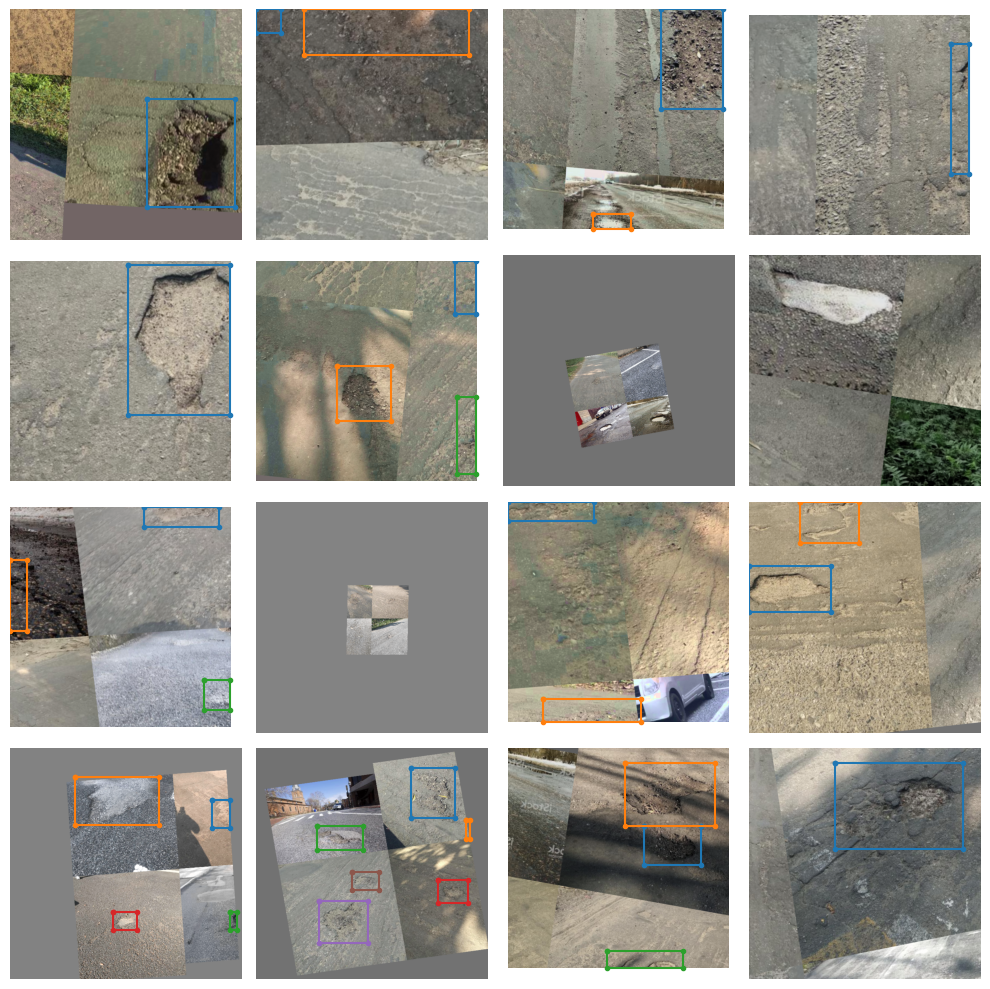

In [ ]:
train_data.dataset.plot(plot_transformed_data=True)

In [ ]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [ ]:
models_to_train = [
    'yolo_nas_l'
]

In [ ]:
CHECKPOINT_DIR = 'checkpoints'

In [ ]:
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train+'_'+str(EPOCHS)+'e',
        ckpt_root_dir=CHECKPOINT_DIR
    )

    model = models.get(
        model_to_train,
        num_classes=len(dataset_params['classes']),
        pretrained_weights="coco"
    )

    trainer.train(
        model=model,
        training_params=train_params,
        train_loader=train_data,
        valid_loader=val_data
    )

[2023-10-16 17:43:54] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:01<00:00, 251MB/s]
[2023-10-16 17:43:55] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l
[2023-10-16 17:44:03] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231016_174403_445067`
[2023-10-16 17:44:03] INFO - sg_trainer.py - Checkpoints directory: checkpoints/yolo_nas_l_10e/RUN_20231016_174403_445067
[2023-10-16 17:44:03] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/yolo_nas_l_10e/RUN_20231016_174403_445067/console_Oct16_17_44_03.txt


/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[2023-10-16 17:44:22] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the mac

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.9382
│   ├── Ppyoloeloss/loss_iou = 0.3155
│   ├── Ppyoloeloss/loss_dfl = 1.6784
│   └── Ppyoloeloss/loss = 3.5662
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.9985
    ├── Ppyoloeloss/loss_iou = 0.2631
    ├── Ppyoloeloss/loss_dfl = 1.7475
    ├── Ppyoloeloss/loss = 3.53
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0029
    ├── F1@0.50 = 0.0
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50:0.95 = 0.0
    ├── Map@0.50:0.95 = 0.0007
    └── F1@0.50:0.95 = 0.0



Validating epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]
[2023-10-16 17:47:40] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_10e/RUN_20231016_174403_445067/ckpt_best.pth
[2023-10-16 17:47:40] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.30660974979400635


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3936
│   │   ├── Epoch N-1      = 1.9382 (↘ -0.5446)
│   │   └── Best until now = 1.9382 (↘ -0.5446)
│   ├── Ppyoloeloss/loss_iou = 0.2398
│   │   ├── Epoch N-1      = 0.3155 (↘ -0.0756)
│   │   └── Best until now = 0.3155 (↘ -0.0756)
│   ├── Ppyoloeloss/loss_dfl = 1.4223
│   │   ├── Epoch N-1      = 1.6784 (↘ -0.2561)
│   │   └── Best until now = 1.6784 (↘ -0.2561)
│   └── Ppyoloeloss/loss = 2.7044
│       ├── Epoch N-1      = 3.5662 (↘ -0.8618)
│       └── Best until now = 3.5662 (↘ -0.8618)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.6574
    │   ├── Epoch N-1      = 1.9985 (↗ 0.6588)
    │   └── Best until now = 1.9985 (↗ 0.6588)
    ├── Ppyoloeloss/loss_iou = 0.2255
    │   ├── Epoch N-1      = 0.2631 (↘ -0.0376)
    │   └── Best until now = 0.2631 (↘ -0.0376)
    ├── Ppyoloeloss/loss_dfl = 1.3942
    │   ├── Epoch N-1      = 1.7475 (↘ -0.3533)
    │   └── Best until now = 1.7475 (↘ -0.3533)
    ├── Ppyoloeloss/loss

Validating epoch 2: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1643
│   │   ├── Epoch N-1      = 1.3936 (↘ -0.2294)
│   │   └── Best until now = 1.3936 (↘ -0.2294)
│   ├── Ppyoloeloss/loss_iou = 0.2361
│   │   ├── Epoch N-1      = 0.2398 (↘ -0.0037)
│   │   └── Best until now = 0.2398 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_dfl = 1.3399
│   │   ├── Epoch N-1      = 1.4223 (↘ -0.0824)
│   │   └── Best until now = 1.4223 (↘ -0.0824)
│   └── Ppyoloeloss/loss = 2.4245
│       ├── Epoch N-1      = 2.7044 (↘ -0.2799)
│       └── Best until now = 2.7044 (↘ -0.2799)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.507
    │   ├── Epoch N-1      = 2.6574 (↘ -1.1504)
    │   └── Best until now = 1.9985 (↘ -0.4916)
    ├── Ppyoloeloss/loss_iou = 0.2504
    │   ├── Epoch N-1      = 0.2255 (↗ 0.0248)
    │   └── Best until now = 0.2255 (↗ 0.0248)
    ├── Ppyoloeloss/loss_dfl = 1.6814
    │   ├── Epoch N-1      = 1.3942 (↗ 0.2872)
    │   └── Best until now = 1.3942 (↗ 0.2872)
    ├── Ppyoloeloss/loss = 

Validating epoch 3: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1205
│   │   ├── Epoch N-1      = 1.1643 (↘ -0.0438)
│   │   └── Best until now = 1.1643 (↘ -0.0438)
│   ├── Ppyoloeloss/loss_iou = 0.2509
│   │   ├── Epoch N-1      = 0.2361 (↗ 0.0148)
│   │   └── Best until now = 0.2361 (↗ 0.0148)
│   ├── Ppyoloeloss/loss_dfl = 1.3994
│   │   ├── Epoch N-1      = 1.3399 (↗ 0.0595)
│   │   └── Best until now = 1.3399 (↗ 0.0595)
│   └── Ppyoloeloss/loss = 2.4475
│       ├── Epoch N-1      = 2.4245 (↗ 0.023)
│       └── Best until now = 2.4245 (↗ 0.023)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.32
    │   ├── Epoch N-1      = 1.507  (↘ -0.1869)
    │   └── Best until now = 1.507  (↘ -0.1869)
    ├── Ppyoloeloss/loss_iou = 0.2018
    │   ├── Epoch N-1      = 0.2504 (↘ -0.0485)
    │   └── Best until now = 0.2255 (↘ -0.0237)
    ├── Ppyoloeloss/loss_dfl = 1.2845
    │   ├── Epoch N-1      = 1.6814 (↘ -0.3969)
    │   └── Best until now = 1.3942 (↘ -0.1097)
    ├── Ppyoloeloss/loss = 2.466

Validating epoch 4: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]
[2023-10-16 17:54:11] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_10e/RUN_20231016_174403_445067/ckpt_best.pth
[2023-10-16 17:54:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.36152759194374084


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1525
│   │   ├── Epoch N-1      = 1.1205 (↗ 0.032)
│   │   └── Best until now = 1.1205 (↗ 0.032)
│   ├── Ppyoloeloss/loss_iou = 0.2377
│   │   ├── Epoch N-1      = 0.2509 (↘ -0.0132)
│   │   └── Best until now = 0.2361 (↗ 0.0016)
│   ├── Ppyoloeloss/loss_dfl = 1.4141
│   │   ├── Epoch N-1      = 1.3994 (↗ 0.0147)
│   │   └── Best until now = 1.3399 (↗ 0.0742)
│   └── Ppyoloeloss/loss = 2.4539
│       ├── Epoch N-1      = 2.4475 (↗ 0.0064)
│       └── Best until now = 2.4245 (↗ 0.0293)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3091
    │   ├── Epoch N-1      = 1.32   (↘ -0.011)
    │   └── Best until now = 1.32   (↘ -0.011)
    ├── Ppyoloeloss/loss_iou = 0.2439
    │   ├── Epoch N-1      = 0.2018 (↗ 0.0421)
    │   └── Best until now = 0.2018 (↗ 0.0421)
    ├── Ppyoloeloss/loss_dfl = 1.5642
    │   ├── Epoch N-1      = 1.2845 (↗ 0.2798)
    │   └── Best until now = 1.2845 (↗ 0.2798)
    ├── Ppyoloeloss/loss = 2.701
    

Validating epoch 5: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0772
│   │   ├── Epoch N-1      = 1.1525 (↘ -0.0753)
│   │   └── Best until now = 1.1205 (↘ -0.0433)
│   ├── Ppyoloeloss/loss_iou = 0.2334
│   │   ├── Epoch N-1      = 0.2377 (↘ -0.0044)
│   │   └── Best until now = 0.2361 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 1.352
│   │   ├── Epoch N-1      = 1.4141 (↘ -0.062)
│   │   └── Best until now = 1.3399 (↗ 0.0122)
│   └── Ppyoloeloss/loss = 2.3366
│       ├── Epoch N-1      = 2.4539 (↘ -0.1173)
│       └── Best until now = 2.4245 (↘ -0.0879)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1024
    │   ├── Epoch N-1      = 1.3091 (↘ -0.2067)
    │   └── Best until now = 1.3091 (↘ -0.2067)
    ├── Ppyoloeloss/loss_iou = 0.2263
    │   ├── Epoch N-1      = 0.2439 (↘ -0.0176)
    │   └── Best until now = 0.2018 (↗ 0.0245)
    ├── Ppyoloeloss/loss_dfl = 1.4149
    │   ├── Epoch N-1      = 1.5642 (↘ -0.1493)
    │   └── Best until now = 1.2845 (↗ 0.1304)
    ├── Ppyoloeloss/loss = 

Validating epoch 6: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]
[2023-10-16 17:59:43] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_10e/RUN_20231016_174403_445067/ckpt_best.pth
[2023-10-16 17:59:43] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3960927128791809


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0662
│   │   ├── Epoch N-1      = 1.0772 (↘ -0.011)
│   │   └── Best until now = 1.0772 (↘ -0.011)
│   ├── Ppyoloeloss/loss_iou = 0.2279
│   │   ├── Epoch N-1      = 0.2334 (↘ -0.0055)
│   │   └── Best until now = 0.2334 (↘ -0.0055)
│   ├── Ppyoloeloss/loss_dfl = 1.2915
│   │   ├── Epoch N-1      = 1.352  (↘ -0.0605)
│   │   └── Best until now = 1.3399 (↘ -0.0484)
│   └── Ppyoloeloss/loss = 2.2817
│       ├── Epoch N-1      = 2.3366 (↘ -0.0549)
│       └── Best until now = 2.3366 (↘ -0.0549)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1132
    │   ├── Epoch N-1      = 1.1024 (↗ 0.0108)
    │   └── Best until now = 1.1024 (↗ 0.0108)
    ├── Ppyoloeloss/loss_iou = 0.2253
    │   ├── Epoch N-1      = 0.2263 (↘ -0.001)
    │   └── Best until now = 0.2018 (↗ 0.0235)
    ├── Ppyoloeloss/loss_dfl = 1.4035
    │   ├── Epoch N-1      = 1.4149 (↘ -0.0114)
    │   └── Best until now = 1.2845 (↗ 0.119)
    ├── Ppyoloeloss/loss = 2.3

Validating epoch 7: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]
[2023-10-16 18:02:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_10e/RUN_20231016_174403_445067/ckpt_best.pth
[2023-10-16 18:02:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.43056684732437134


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0186
│   │   ├── Epoch N-1      = 1.0662 (↘ -0.0476)
│   │   └── Best until now = 1.0662 (↘ -0.0476)
│   ├── Ppyoloeloss/loss_iou = 0.2199
│   │   ├── Epoch N-1      = 0.2279 (↘ -0.0079)
│   │   └── Best until now = 0.2279 (↘ -0.0079)
│   ├── Ppyoloeloss/loss_dfl = 1.2686
│   │   ├── Epoch N-1      = 1.2915 (↘ -0.0229)
│   │   └── Best until now = 1.2915 (↘ -0.0229)
│   └── Ppyoloeloss/loss = 2.2028
│       ├── Epoch N-1      = 2.2817 (↘ -0.0789)
│       └── Best until now = 2.2817 (↘ -0.0789)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9891
    │   ├── Epoch N-1      = 1.1132 (↘ -0.1241)
    │   └── Best until now = 1.1024 (↘ -0.1133)
    ├── Ppyoloeloss/loss_iou = 0.2162
    │   ├── Epoch N-1      = 0.2253 (↘ -0.0091)
    │   └── Best until now = 0.2018 (↗ 0.0144)
    ├── Ppyoloeloss/loss_dfl = 1.2748
    │   ├── Epoch N-1      = 1.4035 (↘ -0.1287)
    │   └── Best until now = 1.2845 (↘ -0.0097)
    ├── Ppyoloeloss/los

Validating epoch 8: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]
[2023-10-16 18:06:21] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_10e/RUN_20231016_174403_445067/ckpt_best.pth
[2023-10-16 18:06:21] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4464646279811859
Validating epoch 9: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9437
│   │   ├── Epoch N-1      = 0.9825 (↘ -0.0388)
│   │   └── Best until now = 0.9825 (↘ -0.0388)
│   ├── Ppyoloeloss/loss_iou = 0.2035
│   │   ├── Epoch N-1      = 0.211  (↘ -0.0075)
│   │   └── Best until now = 0.211  (↘ -0.0075)
│   ├── Ppyoloeloss/loss_dfl = 1.1817
│   │   ├── Epoch N-1      = 1.2382 (↘ -0.0565)
│   │   └── Best until now = 1.2382 (↘ -0.0565)
│   └── Ppyoloeloss/loss = 2.0433
│       ├── Epoch N-1      = 2.1292 (↘ -0.086)
│       └── Best until now = 2.1292 (↘ -0.086)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9611
    │   ├── Epoch N-1      = 0.8999 (↗ 0.0612)
    │   └── Best until now = 0.8999 (↗ 0.0612)
    ├── Ppyoloeloss/loss_iou = 0.2285
    │   ├── Epoch N-1      = 0.2393 (↘ -0.0108)
    │   └── Best until now = 0.2018 (↗ 0.0267)
    ├── Ppyoloeloss/loss_dfl = 1.3805
    │   ├── Epoch N-1      = 1.4207 (↘ -0.0401)
    │   └── Best until now = 1.2748 (↗ 0.1058)
    ├── Ppyoloeloss/loss = 2

[2023-10-16 18:12:00] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 10: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


In [ ]:
os.makedirs('/content/gdrive/My Drive/Yolo_Nas/images/', exist_ok=True)

In [ ]:
import torch
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model = models.get(
    model_name='yolo_nas_l',
    checkpoint_path='/content/gdrive/My Drive/Yolo_Nas/checkpoints/yolo_nas_l_10e/RUN_20231016_174403_445067/ckpt_best.pth',
    num_classes=1
).to(device)

[2023-10-16 18:15:25] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/gdrive/My Drive/Yolo_Nas/checkpoints/yolo_nas_l_10e/RUN_20231016_174403_445067/ckpt_best.pth EMA checkpoint.


In [ ]:
ROOT_TEST = '/content/gdrive/My Drive/Yolo_Nas/pothole/test/images/'
all_images = os.listdir(ROOT_TEST)

In [ ]:
for image in tqdm(all_images, total=len(all_images)):
    image_path = os.path.join(ROOT_TEST, image)
    out = model.predict(image_path)
    out.save('/content/gdrive/My Drive/Yolo_Nas/images/')
    os.rename(
        '/content/gdrive/My Drive/Yolo_Nas/images/pred_0.jpg',
        os.path.join('/content/gdrive/My Drive/Yolo_Nas/images/', image)
    )

  0%|          | 0/25 [00:00<?, ?it/s]

[2023-10-16 18:17:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/visualization/utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("gist_rainbow", num_classes)
[2023-10-16 18:17:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-10-16 18:17:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-10-16 18:17:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `f

In [ ]:
classes = ['Road-hole']

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        class_name = classes[int(labels[box_num])]

        color = (0, 0, 255)

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=lw,
            lineType=cv2.LINE_AA
        )

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name,
            0,
            fontScale=lw / 3,
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3

        cv2.rectangle(
            image,
            (p1[0], p2[1]), new_p2,
            color=color,
            thickness=-1,
            lineType=cv2.LINE_AA
        )
        cv2.putText(
            image,
            class_name,
            (p1[0], p2[1] + h + 2 if outside else p2[1]),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=lw/3,
            color=(255, 255, 255),
            thickness=tf,
            lineType=cv2.LINE_AA
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()

    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)

    num_images = len(all_training_images)

    if num_samples == -1:
        num_samples = num_images

    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.figure(figsize=(12, 9))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

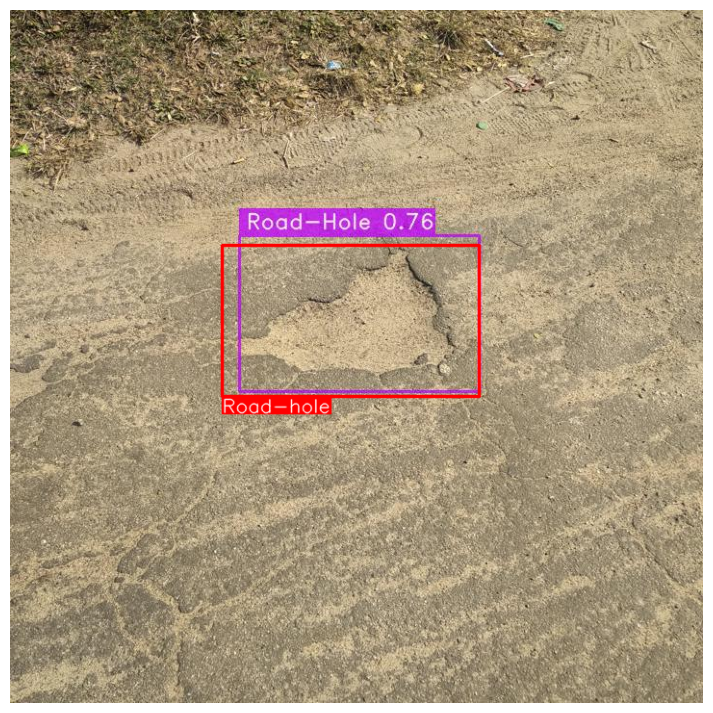

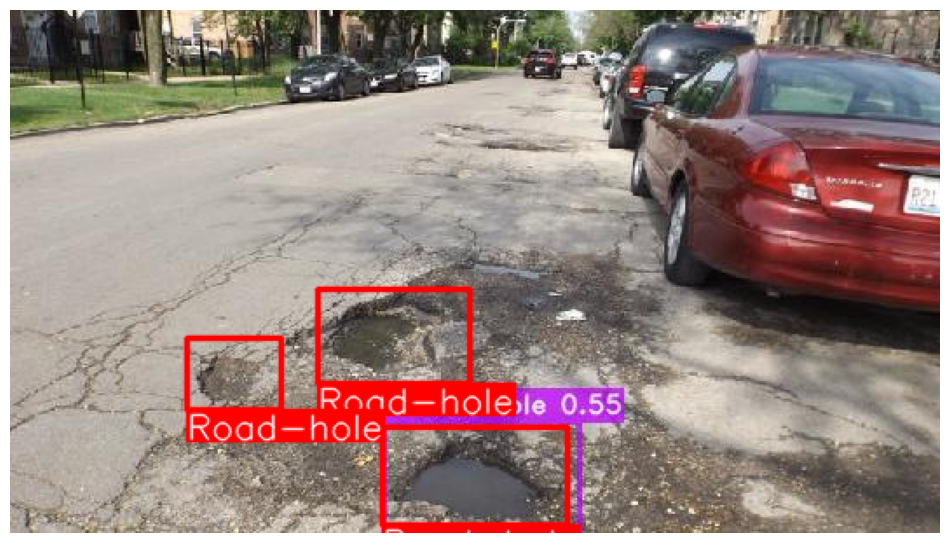

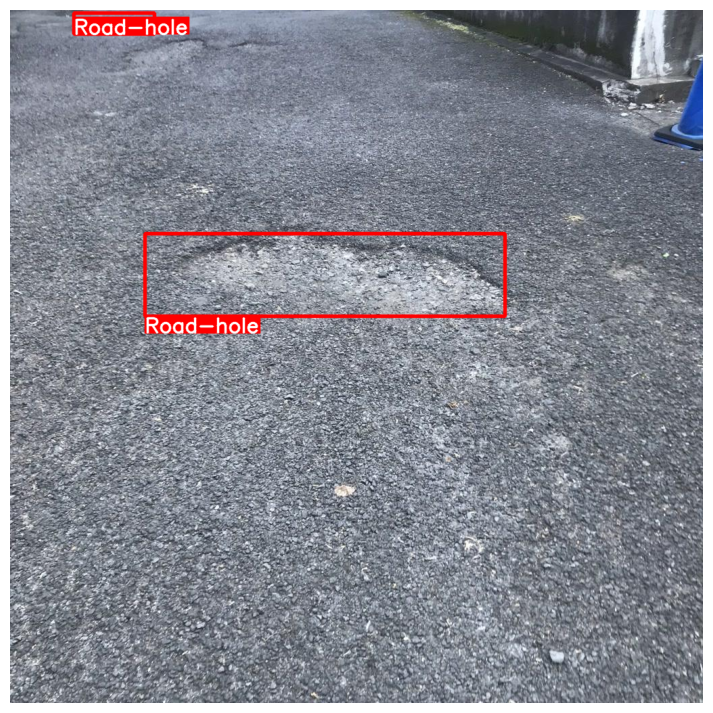

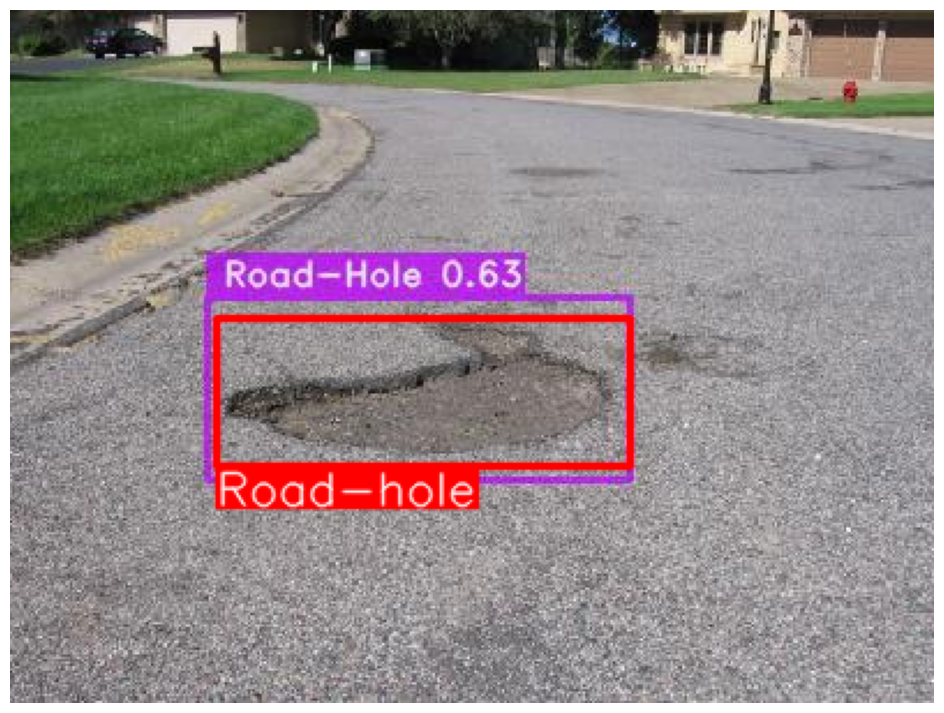

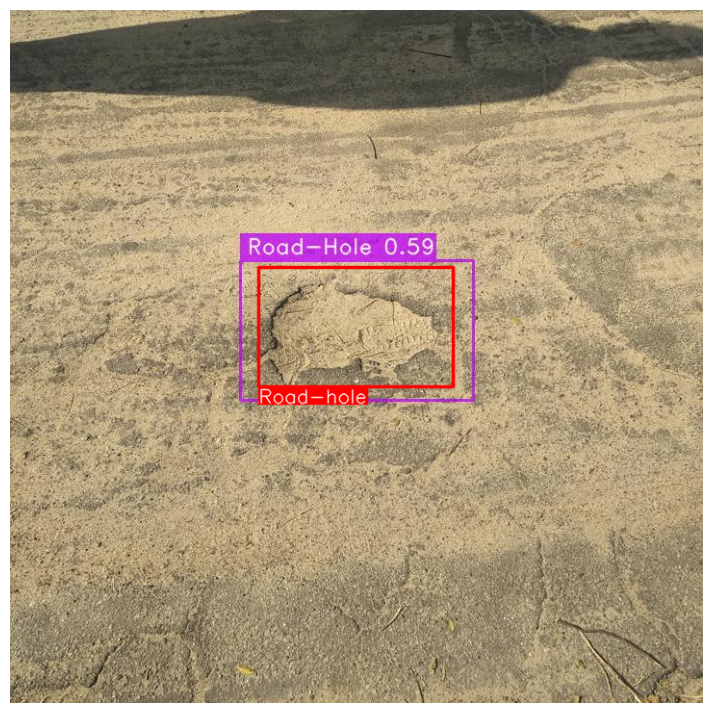

In [ ]:
# Visualize a few training images.
plot(
    image_path='/content/gdrive/My Drive/Yolo_Nas/images/',
    label_path='/content/gdrive/My Drive/Yolo_Nas/pothole/test/labels/',
    num_samples=5,
)